In [2]:
import os 
os.chdir("..")


In [3]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
mode = "frequencies"
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params(pars)

total_time, dt = get_total_time_dt(params, ppp=1000)
times = np.arange(0, total_time+ dt, dt)

In [5]:
def load_liks(itrajj, mode="frequencies"):
    pars = give_def_params_discrimination(flip=0, mode = mode)
    params, exp_path = check_params(pars)

    total_time, dt = get_total_time_dt(params, ppp=1000)
    
    logliks =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    l0,l1 = logliks[:,0], logliks[:,1]
    log_lik_ratio = l1 - l0  ###

    pars = give_def_params_discrimination(flip=1, mode=mode)
    params, exp_path = check_params(pars)
    total_time, dt = get_total_time_dt(params, ppp=1000)
    logliks_swap =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    log_lik_ratio_swap = logliks_swap[:,0] - logliks_swap[:,1]  
    
    return log_lik_ratio, log_lik_ratio_swap

In [6]:
indis = np.logspace(2,np.log10(len(times)), 10)
indis = [int(k) for k in indis]

In [7]:
def decide_stop(l, a, b):
    if a<=l<=b:
        return 0
    else:
        return 1

In [15]:
deter, stoch = {}, {}
deter["h0/h1"]  = []
deter["h1/h0"] = []
stoch["h1/h0"] = {}
stoch["h0/h1"] = {}
stop = {}
stop["h1/h0"] = {i:[] for i in range(1,2)}
stop["h0/h1"] = {i:[] for i in range(1,2)}


boundsB = np.arange(1,10,.1)
#boundsA = np.sort(-boundsB)[::-1]
#for ind_bound in range(len(boundsB)):
#    stoch["h0/h1"][ind_bound] = []
#    stoch["h1/h0"][ind_bound] = []    

    
itraj = 1
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)

def get_stop_time(log_lik_ratio,b):
    ind_times = np.argmin(np.logical_and(log_lik_ratio < b, log_lik_ratio > -b))
    if ind_times !=0:
        return times[ind_times]
    else:
        return np.nan

ll = log_lik_ratio
ll0 = log_lik_ratio_swap
for time_index in tqdm(indis):
    h0_deter = log_lik_ratio[time_index] <= 0
    h1_deter = log_lik_ratio_swap[time_index] <= 0
    deter["h0/h1"].append(int(h0_deter))
    deter["h1/h0"].append(int(h0_deter))
for b in boundsB:
    stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
    stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))
n=1
Ntrajs = 5000

for itraj in tqdm(range(2,Ntrajs)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
        stop["h0/h1"][itraj] = []
        stop["h1/h0"][itraj] = []
        ll += log_lik_ratio
        ll0+= log_lik_ratio_swap
        n+=1
        for ind, time_index in enumerate(indis):
            h0_deter = log_lik_ratio[time_index] <= 0
            h1_deter = log_lik_ratio_swap[time_index] <= 0
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
            
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
        for b in boundsB:
            stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
            stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))
    except Exception:
        pass

100%|██████████| 4998/4998 [00:17<00:00, 285.79it/s] 


In [8]:
stopps1 = [np.array(stop["h0/h1"][k])[~np.isnan(stop["h0/h1"][k])] for k in stop["h0/h1"].keys()]
stopps0 = [np.array(stop["h1/h0"][k])[~np.isnan(stop["h1/h0"][k])] for k in stop["h1/h0"].keys()]

ind_max_traj1 = np.argmax([len(k) for k in stopps1])
ind_max_traj0 = np.argmax([len(k) for k in stopps0])

In [9]:
stop_time1 = stopps1[ind_max_traj1]
stop_time1_sq = stopps1[ind_max_traj1]**2
ns1 = 2*np.ones(len(stopps1[ind_max_traj1]))

stop_time0 = stopps0[ind_max_traj0]
stop_time0_sq = stopps0[ind_max_traj1]**2
ns0 = 2*np.ones(len(stopps0[ind_max_traj0]))

itrajs1 = list(range(1,Ntraj))
itrajs0 = list(range(1,Ntraj))
itrajs1.remove(ind_max_traj1+1)
itrajs0.remove(ind_max_traj0+1)

for i in tqdm(itrajs1):
    for ind,b in enumerate(boundsB[:len(stopps1[ind_max_traj1])]):
        try: 
            stop_time1[ind] += (stopps1[i][ind] - stop_time1[ind])/ns1[ind]
            stop_time1_sq[ind] += (stopps1[i][ind]**2 - stop_time1_sq[ind])/ns1[ind]
            
            ns1[ind] +=1
        except Exception:
            pass
        
for i in tqdm(itrajs0):
    for ind,b in enumerate(boundsB[:len(stopps0[ind_max_traj0])]):
        try: 
            stop_time0[ind] += (stopps0[i][ind] - stop_time0[ind])/ns0[ind]
            stop_time0_sq[ind] += (stopps0[i][ind]**2 - stop_time0_sq[ind])/ns1[ind]
            
            ns0[ind] +=1
        except Exception:
            pass

100%|██████████| 2998/2998 [00:00<00:00, 5699.39it/s]


In [10]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))

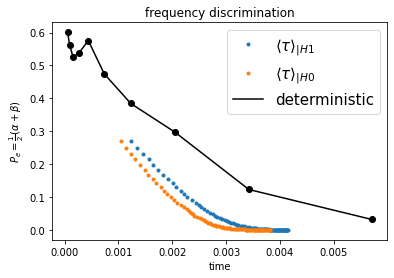

In [12]:
ax = plt.subplot(111)
plt.title("frequency discrimination")
lin=6
ax.plot(stop_time1, [avg_err_alpha(b) for b in boundsB[:len(stopps1)]], '.',label=r'$\langle \tau \rangle_{|H1}$', linewidth=lin)
ax.plot(stop_time0, [avg_err_alpha(b) for b in boundsB[:len(stopps0)]], '.',label=r'$\langle \tau \rangle_{|H0}$', linewidth=lin)
ax.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]),color="black", label="deterministic")
ax.scatter([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]), color="black")

ax.set_xlabel("time")
ax.set_ylabel(r'$P_e = \frac{1}{2} (\alpha + \beta)$')
ax.legend(prop={"size":15})

No handles with labels found to put in legend.


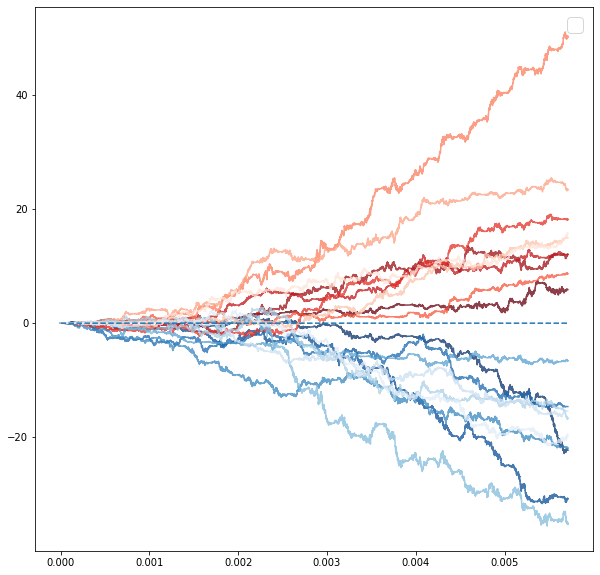

In [ ]:

colors1 = plt.get_cmap("Reds")
colors0 = plt.get_cmap("Blues")

plt.figure(figsize=(10,10))
alphaMean=0.6
plt.plot(times, ll[:-1]/len(,linewidth=10, alpha=alphaMean,  color="red", label=r'$\langle \ell_{|H_1}\rangle$')
Ntraj = 10
c1 = colors1(np.linspace(0,1,Ntraj))[::-1]
c0 = colors0(np.linspace(0,1,Ntraj))[::-1]
             
for ii, itraj in enumerate(range(1,Ntraj)):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
    plt.plot(times,log_lik_ratio[:-1], c=c1[ii], alpha=0.75)
    plt.plot(times, log_lik_ratio_swap[:-1],c=c0[ii], alpha=0.75)
plt.plot(times,ll0[:-1], linewidth=10, alpha=alphaMean, color="blue", label=r'$\langle \ell_{|H_0}\rangle$')
plt.plot(times, np.zeros(len(ll0)-1),"--")

plt.legend(prop={"size":20})

In [476]:
import os 
freq_dir = get_def_path(mode="continuous")+"freq_discrimination/"
os.makedirs(freq_dir, exist_ok=True)

In [477]:
np.save(freq_dir+"mean_likelihood_0", ll0)
np.save(freq_dir+"mean_likelihood_1", ll)
np.save(freq_dir+"boundsB", boundsB)
np.save(freq_dir+"stop_time1",stop_time1)
np.save(freq_dir+"stop_time0",stop_time0)
np.save(freq_dir+"alpha_deter",np.array(deter["h0/h1"]))
np.save(freq_dir+"beta_deter",np.array(deter["h1/h0"]))